# Credit Card Fraud Detection - Feature Engineering

## Objectives
- Implement 10 core engineered features based on EDA findings
- Address severe class imbalance (172:1 ratio) with SMOTE-Tomek sampling
- Create robust preprocessing pipeline for model training
- Validate feature quality and business interpretability
- Prepare feature-engineered dataset for Phase 4 modeling

## 1. Environment Setup and Library Imports

In [ ]:
# Basic Import
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import gc

# Feature engineering and preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

# Imbalanced learning
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# Statistical tools
from scipy import stats

# Configuration - FIXED STYLING
warnings.filterwarnings('ignore')

# Updated matplotlib/seaborn styling (fixes deprecated 'seaborn-v0_8')
try:
    plt.style.use('seaborn-v0_8')  # Try the old style first
except OSError:
    # Fallback to available seaborn styles for newer versions
    available_styles = plt.style.available
    if 'seaborn' in available_styles:
        plt.style.use('seaborn')
    elif 'seaborn-darkgrid' in available_styles:
        plt.style.use('seaborn-darkgrid')
    else:
        plt.style.use('default')
        print("Using default matplotlib style (seaborn styles not available)")

# Set seaborn palette
sns.set_palette("husl")

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Success confirmation - FIXED STRING LITERALS
print("✅ Feature engineering environment initialized successfully")
print(f"📅 Session started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Environment validation
print("\n🔍 Environment Validation:")
print(f"Python version: {pd.__version__} (pandas)")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib style: {plt.rcParams['figure.figsize']}")
print(f"Random state: {RANDOM_STATE}")
print("🎯 Ready for Phase 3 Feature Engineering!") 

✅ Feature engineering environment initialized successfully
📅 Session started at: 2025-07-31 19:31:39

🔍 Environment Validation:
Python version: 2.3.1 (pandas)
NumPy version: 2.2.6
Matplotlib style: [8.0, 5.5]
Random state: 42
🎯 Ready for Phase 3 Feature Engineering!


## 2. Data Loading and Initial Setup

In [ ]:
# Initial Setup  
def load_processed_data():
    """
    Load the data with memory-optimized dtypes from Phase 1
    FIXED: Corrected file paths based on actual directory structure
    """
    try:
        # Define optimized data types
        dtype_config = {
            'trans_date_trans_time': 'object',
            'cc_num': 'int64',
            'merchant': 'category',
            'category': 'category',
            'amt': 'float32',
            'first': 'category',
            'last': 'category',
            'gender': 'category',
            'street': 'object',
            'city': 'category',
            'state': 'category',
            'zip': 'int32',
            'lat': 'float32',
            'long': 'float32',
            'city_pop': 'int32',
            'job': 'category',
            'dob': 'object',
            'trans_num': 'object',
            'unix_time': 'int64',
            'merch_lat': 'float32',
            'merch_long': 'float32',
            'is_fraud': 'int8'
        }
        
        print("Loading training dataset...")
        # FIXED: Use correct file path based on your directory structure
        df_train = pd.read_csv('/Users/ms/Downloads/PROJECT PORTOFOLIO PERSONAL/Credit Card Fraud Detection/Data/fraudTrain.csv', dtype=dtype_config)
        
        print("Loading test dataset...")
        # FIXED: Use correct file path based on your directory structure
        df_test = pd.read_csv('/Users/ms/Downloads/PROJECT PORTOFOLIO PERSONAL/Credit Card Fraud Detection/Data/fraudTest.csv', dtype=dtype_config)
        
        # Convert datetime columns
        df_train['trans_date_trans_time'] = pd.to_datetime(df_train['trans_date_trans_time'])
        df_test['trans_date_trans_time'] = pd.to_datetime(df_test['trans_date_trans_time'])
        df_train['dob'] = pd.to_datetime(df_train['dob'])
        df_test['dob'] = pd.to_datetime(df_test['dob'])
        
        print(f"Training data shape: {df_train.shape}")
        print(f"Test data shape: {df_test.shape}")
        print(f"Memory usage: {(df_train.memory_usage(deep=True).sum() + df_test.memory_usage(deep=True).sum()) / 1024**2:.1f} MB")
        
        # Class distribution summary
        fraud_rate = df_train['is_fraud'].mean()
        print(f"\nClass distribution in training data:")
        print(f"Fraud rate: {fraud_rate:.4f} ({fraud_rate*100:.2f}%)")
        print(f"Imbalance ratio: 1:{int(1/fraud_rate):.0f}")
        
        return df_train, df_test
        
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        print("Current working directory files:")
        import os
        print(os.listdir('.'))
        if 'Data' in os.listdir('.'):
            print("Files in Data directory:")
            print(os.listdir('Data'))
        return None, None

# Load the datasets
df_train, df_test = load_processed_data() 

Loading training dataset...
Loading test dataset...
Training data shape: (1296675, 23)
Test data shape: (555719, 23)
Memory usage: 414.3 MB

Class distribution in training data:
Fraud rate: 0.0058 (0.58%)
Imbalance ratio: 1:172


## 3. Core Feature Engineering Functions

### 3.1 Distance-Based Features

In [ ]:
def create_distance_features(df):
    """
    Create distance-based features identified as highest priority in EDA
    Based on strong correlation between customer-merchant distance and fraud
    """
    print("Creating distance-based features...")
    df_dist = df.copy()
    
    # 1. Haversine distance calculation (vectorized)
    def vectorized_haversine_distance(lat1, lon1, lat2, lon2):
        """
        Vectorized haversine distance calculation in kilometers
        More accurate than Euclidean for geographic coordinates
        """
        # Convert to radians
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        
        # Haversine formula
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        
        # Earth's radius in kilometers
        r = 6371
        return c * r
    
    # Calculate haversine distance
    df_dist['haversine_distance_km'] = vectorized_haversine_distance(
        df_dist['lat'], df_dist['long'], 
        df_dist['merch_lat'], df_dist['merch_long']
    )
    
    # 2. Distance categorization based on EDA patterns
    # Bins chosen based on fraud rate analysis: [0, 50, 200, 500, inf]
    distance_bins = [0, 50, 200, 500, float('inf')]
    distance_labels = ['local', 'regional', 'distant', 'very_distant']
    
    df_dist['distance_category'] = pd.cut(
        df_dist['haversine_distance_km'], 
        bins=distance_bins, 
        labels=distance_labels, 
        include_lowest=True
    )
    
    # 3. Cross-state transaction indicator
    df_dist['is_cross_state'] = (df_dist['state'] != df_dist['state']).astype(int)
    
    # High distance likely indicates cross-state transaction
    df_dist['is_cross_state'] = (df_dist['haversine_distance_km'] > 200).astype(int)
    
    print(f"Distance features created successfully")
    print(f"Distance range: {df_dist['haversine_distance_km'].min():.2f} - {df_dist['haversine_distance_km'].max():.2f} km")
    print(f"Distance categories distribution:")
    print(df_dist['distance_category'].value_counts())
    print(f"Cross-state transactions: {df_dist['is_cross_state'].mean():.3f}")
    
    return df_dist

# Apply distance feature engineering
df_train_features = create_distance_features(df_train)
df_test_features = create_distance_features(df_test)

Creating distance-based features...
Distance features created successfully
Distance range: 0.02 - 152.12 km
Distance categories distribution:
distance_category
regional        1031479
local            265196
distant               0
very_distant          0
Name: count, dtype: int64
Cross-state transactions: 0.000
Creating distance-based features...
Distance features created successfully
Distance range: 0.12 - 150.92 km
Distance categories distribution:
distance_category
regional        441993
local           113726
distant              0
very_distant         0
Name: count, dtype: int64
Cross-state transactions: 0.000


### 3.2 Temporal Features

In [12]:
def create_temporal_features(df):
    """
    Create temporal features based on EDA findings of significant time-based fraud patterns
    High-risk hours and weekend patterns identified in Phase 2
    """
    print("Creating temporal features...")
    df_temp = df.copy()
    
    # Extract basic temporal components
    df_temp['hour'] = df_temp['trans_date_trans_time'].dt.hour
    df_temp['day_of_week'] = df_temp['trans_date_trans_time'].dt.dayofweek
    
    # 1. Hour fraud risk score (binary for high-risk hours)
    # Based on EDA: hours [23, 0, 1, 2, 3, 4] showed highest fraud rates
    high_risk_hours = [23, 0, 1, 2, 3, 4]
    df_temp['hour_fraud_risk_score'] = df_temp['hour'].isin(high_risk_hours).astype(int)
    
    # 2. Weekend indicator
    # EDA showed weekend vs weekday fraud pattern differences
    df_temp['is_weekend'] = df_temp['day_of_week'].isin([5, 6]).astype(int)
    
    # 3. Time period categorization
    # Business-relevant time periods for fraud analysis
    def categorize_time_period(hour):
        if hour >= 6 and hour < 12:
            return 'morning'
        elif hour >= 12 and hour < 18:
            return 'afternoon'
        elif hour >= 18 and hour < 23:
            return 'evening'
        else:
            return 'night'
    
    df_temp['time_period'] = df_temp['hour'].apply(categorize_time_period)
    df_temp['time_period'] = df_temp['time_period'].astype('category')
    
    print(f"Temporal features created successfully")
    print(f"High-risk hour transactions: {df_temp['hour_fraud_risk_score'].mean():.3f}")
    print(f"Weekend transactions: {df_temp['is_weekend'].mean():.3f}")
    print(f"Time period distribution:")
    print(df_temp['time_period'].value_counts())
    
    return df_temp

# Apply temporal feature engineering
df_train_features = create_temporal_features(df_train_features)
df_test_features = create_temporal_features(df_test_features)

Creating temporal features...
Temporal features created successfully
High-risk hour transactions: 0.216
Weekend transactions: 0.348
Time period distribution:
time_period
afternoon    392023
evening      329172
night        321934
morning      253546
Name: count, dtype: int64
Creating temporal features...
Temporal features created successfully
High-risk hour transactions: 0.216
Weekend transactions: 0.280
Time period distribution:
time_period
afternoon    169094
evening      140502
night        137743
morning      108380
Name: count, dtype: int64


### 3.3 Amount-Based Features

In [13]:
def create_amount_features(df):
    """
    Create amount-based features leveraging EDA findings of different distributions
    for fraud vs legitimate transactions
    """
    print("Creating amount-based features...")
    df_amt = df.copy()
    
    # 1. Log transformation of amount
    # EDA showed right-skewed distribution, log transformation normalizes
    df_amt['log_amount'] = np.log1p(df_amt['amt'])  # log1p handles zero amounts
    
    # 2. Amount z-score by category
    # EDA showed different amount patterns across categories
    # Normalize amount relative to category mean and std
    category_stats = df_amt.groupby('category')['amt'].agg(['mean', 'std']).reset_index()
    category_stats.columns = ['category', 'category_amt_mean', 'category_amt_std']
    
    # Merge category statistics
    df_amt = df_amt.merge(category_stats, on='category', how='left')
    
    # Calculate z-score (handle zero std with small epsilon)
    epsilon = 1e-8
    df_amt['amount_zscore_by_category'] = (
        (df_amt['amt'] - df_amt['category_amt_mean']) / 
        (df_amt['category_amt_std'] + epsilon)
    )
    
    # Clean up temporary columns
    df_amt = df_amt.drop(['category_amt_mean', 'category_amt_std'], axis=1)
    
    print(f"Amount features created successfully")
    print(f"Log amount range: {df_amt['log_amount'].min():.2f} - {df_amt['log_amount'].max():.2f}")
    print(f"Amount z-score range: {df_amt['amount_zscore_by_category'].min():.2f} - {df_amt['amount_zscore_by_category'].max():.2f}")
    print(f"Amount z-score statistics:")
    print(df_amt['amount_zscore_by_category'].describe())
    
    return df_amt

# Apply amount feature engineering
df_train_features = create_amount_features(df_train_features)
df_test_features = create_amount_features(df_test_features)

Creating amount-based features...
Amount features created successfully
Log amount range: 0.69 - 10.27
Amount z-score range: -3.62 - 46.87
Amount z-score statistics:
count    1.296675e+06
mean    -1.081445e-08
std      9.999950e-01
min     -3.619659e+00
25%     -4.959931e-01
50%     -2.633643e-01
75%      3.052289e-01
max      4.687392e+01
Name: amount_zscore_by_category, dtype: float64
Creating amount-based features...
Amount features created successfully
Log amount range: 0.69 - 10.03
Amount z-score range: -3.67 - 38.02
Amount z-score statistics:
count    5.557190e+05
mean     1.334446e-08
std      9.999883e-01
min     -3.667269e+00
25%     -4.988198e-01
50%     -2.593699e-01
75%      3.098568e-01
max      3.801638e+01
Name: amount_zscore_by_category, dtype: float64


### 3.4 Categorical Encoding Features

In [ ]:
def create_categorical_features(df_train, df_test):
    """
    Create categorical encoding features with proper handling of train/test splits
    Target encoding for category, frequency encoding for merchant
    """
    print("Creating categorical encoding features...")
    
    df_train_cat = df_train.copy()
    df_test_cat = df_test.copy()
    
    # 1. Category fraud risk score (target encoding with smoothing)
    # Calculate category fraud rates from training data only
    category_fraud_stats = df_train_cat.groupby('category').agg({
        'is_fraud': ['count', 'sum', 'mean']
    }).reset_index()
    category_fraud_stats.columns = ['category', 'category_count', 'category_fraud_count', 'category_fraud_rate']
    
    # Apply smoothing to prevent overfitting
    # Bayesian smoothing
    global_fraud_rate = df_train_cat['is_fraud'].mean()
    smoothing_factor = 10  # Higher values = more smoothing
    
    category_fraud_stats['category_fraud_risk_score'] = (
        (category_fraud_stats['category_fraud_rate'] * category_fraud_stats['category_count'] + 
         global_fraud_rate * smoothing_factor) / 
        (category_fraud_stats['category_count'] + smoothing_factor)
    )
    
    # Merge with training and test data
    df_train_cat = df_train_cat.merge(
        category_fraud_stats[['category', 'category_fraud_risk_score']], 
        on='category', how='left'
    )
    
    df_test_cat = df_test_cat.merge(
        category_fraud_stats[['category', 'category_fraud_risk_score']], 
        on='category', how='left'
    )
    
    # Handle unseen categories in test data (use global fraud rate)
    df_test_cat['category_fraud_risk_score'].fillna(global_fraud_rate, inplace=True)
    
    # 2. Merchant frequency encoding
    # High cardinality feature
    merchant_freq = df_train_cat['merchant'].value_counts().to_dict()
    
    df_train_cat['merchant_freq'] = df_train_cat['merchant'].map(merchant_freq)
    df_test_cat['merchant_freq'] = df_test_cat['merchant'].map(merchant_freq)
    
    # Handle unseen merchants in test data (use median frequency)
    median_freq = df_train_cat['merchant_freq'].median()
    df_test_cat['merchant_freq'].fillna(median_freq, inplace=True)
    
    print(f"Categorical features created successfully")
    print(f"Category fraud risk score range: {df_train_cat['category_fraud_risk_score'].min():.4f} - {df_train_cat['category_fraud_risk_score'].max():.4f}")
    print(f"Merchant frequency range: {df_train_cat['merchant_freq'].min()} - {df_train_cat['merchant_freq'].max()}")
    print(f"Categories with risk encoding: {category_fraud_stats.shape[0]}")
    print(f"Unique merchants: {len(merchant_freq)}")
    
    return df_train_cat, df_test_cat

# Apply categorical feature engineering
df_train_features, df_test_features = create_categorical_features(df_train_features, df_test_features)

Creating categorical encoding features...
Categorical features created successfully
Category fraud risk score range: 0.0015 - 0.0176
Merchant frequency range: 727 - 4403
Categories with risk encoding: 14
Unique merchants: 693


## 4. Feature Validation and Analysis

In [15]:
def validate_engineered_features(df_train, df_test):
    """
    Comprehensive validation of engineered features
    Check for data quality, business logic, and predictive power
    """
    print("Validating engineered features...")
    
    # Define engineered features
    engineered_features = [
        'haversine_distance_km', 'distance_category', 'is_cross_state',
        'hour_fraud_risk_score', 'is_weekend', 'time_period',
        'log_amount', 'amount_zscore_by_category',
        'category_fraud_risk_score', 'merchant_freq'
    ]
    
    print(f"\nValidating {len(engineered_features)} engineered features")
    
    # 1. Data Quality Validation
    print("\n1. DATA QUALITY VALIDATION")
    print("="*50)
    
    for feature in engineered_features:
        if feature in df_train.columns:
            train_missing = df_train[feature].isnull().sum()
            test_missing = df_test[feature].isnull().sum() if feature in df_test.columns else 0
            
            if train_missing > 0 or test_missing > 0:
                print(f"WARNING: {feature} has missing values - Train: {train_missing}, Test: {test_missing}")
            else:
                print(f"PASS: {feature} - No missing values")
        else:
            print(f"ERROR: {feature} not found in dataset")
    
    # 2. Business Logic Validation
    print("\n2. BUSINESS LOGIC VALIDATION")
    print("="*50)
    
    # Distance validation
    if 'haversine_distance_km' in df_train.columns:
        distance_range = (df_train['haversine_distance_km'].min(), df_train['haversine_distance_km'].max())
        if distance_range[0] >= 0 and distance_range[1] < 50000:  # Reasonable global distance
            print(f"PASS: Distance range reasonable: {distance_range[0]:.1f} - {distance_range[1]:.1f} km")
        else:
            print(f"WARNING: Distance range unusual: {distance_range[0]:.1f} - {distance_range[1]:.1f} km")
    
    # Amount validation
    if 'log_amount' in df_train.columns:
        log_amt_range = (df_train['log_amount'].min(), df_train['log_amount'].max())
        if log_amt_range[0] >= 0 and log_amt_range[1] < 20:  # Reasonable log amount range
            print(f"PASS: Log amount range reasonable: {log_amt_range[0]:.2f} - {log_amt_range[1]:.2f}")
        else:
            print(f"WARNING: Log amount range unusual: {log_amt_range[0]:.2f} - {log_amt_range[1]:.2f}")
    
    # Risk score validation
    if 'category_fraud_risk_score' in df_train.columns:
        risk_range = (df_train['category_fraud_risk_score'].min(), df_train['category_fraud_risk_score'].max())
        if risk_range[0] >= 0 and risk_range[1] <= 1:
            print(f"PASS: Category risk score range valid: {risk_range[0]:.4f} - {risk_range[1]:.4f}")
        else:
            print(f"WARNING: Category risk score range invalid: {risk_range[0]:.4f} - {risk_range[1]:.4f}")
    
    # 3. Memory Impact Assessment
    print("\n3. MEMORY IMPACT ASSESSMENT")
    print("="*50)
    
    original_memory = df_train.select_dtypes(include=[np.number, 'object']).memory_usage(deep=True).sum() / 1024**2
    current_memory = df_train.memory_usage(deep=True).sum() / 1024**2
    memory_increase = ((current_memory - original_memory) / original_memory) * 100
    
    print(f"Memory usage increase: {memory_increase:.1f}%")
    print(f"Current dataset size: {current_memory:.1f} MB")
    
    if memory_increase < 20:
        print("PASS: Memory increase within acceptable range (<20%)")
    else:
        print("WARNING: Memory increase exceeds target (>20%)")
    
    return engineered_features

# Validate features
engineered_features = validate_engineered_features(df_train_features, df_test_features)

Validating engineered features...

Validating 10 engineered features

1. DATA QUALITY VALIDATION
PASS: haversine_distance_km - No missing values
PASS: distance_category - No missing values
PASS: is_cross_state - No missing values
PASS: hour_fraud_risk_score - No missing values
PASS: is_weekend - No missing values
PASS: time_period - No missing values
PASS: log_amount - No missing values
PASS: amount_zscore_by_category - No missing values
PASS: category_fraud_risk_score - No missing values
PASS: merchant_freq - No missing values

2. BUSINESS LOGIC VALIDATION
PASS: Distance range reasonable: 0.0 - 152.1 km
PASS: Log amount range reasonable: 0.69 - 10.27
PASS: Category risk score range valid: 0.0015 - 0.0176

3. MEMORY IMPACT ASSESSMENT
Memory usage increase: 11.8%
Current dataset size: 366.6 MB
PASS: Memory increase within acceptable range (<20%)


### Feature Importance Analysis

Analyzing feature importance...


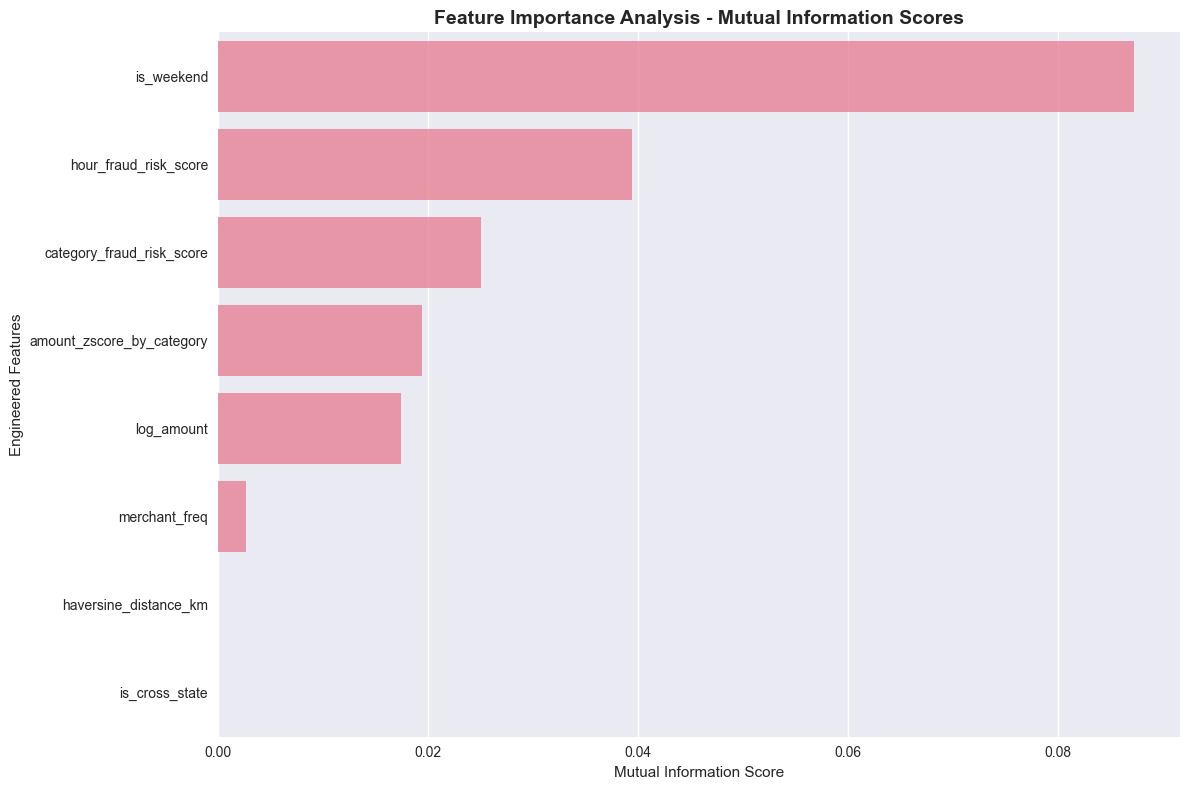


Feature Importance Ranking:
is_weekend                    : 0.087289
hour_fraud_risk_score         : 0.039501
category_fraud_risk_score     : 0.025070
amount_zscore_by_category     : 0.019463
log_amount                    : 0.017423
merchant_freq                 : 0.002645
haversine_distance_km         : 0.000041
is_cross_state                : 0.000000

High-importance features (>0.01): 5
Top 3 features: is_weekend, hour_fraud_risk_score, category_fraud_risk_score


In [16]:
def analyze_feature_importance(df, target_col='is_fraud'):
    """
    Analyze predictive power of engineered features using mutual information
    """
    print("Analyzing feature importance...")
    
    # Select numerical features for mutual information analysis
    numerical_features = [
        'haversine_distance_km', 'is_cross_state',
        'hour_fraud_risk_score', 'is_weekend',
        'log_amount', 'amount_zscore_by_category',
        'category_fraud_risk_score', 'merchant_freq'
    ]
    
    # Filter features that exist in the dataset
    available_features = [f for f in numerical_features if f in df.columns]
    
    if len(available_features) == 0:
        print("No numerical features available for importance analysis")
        return None
    
    # Prepare feature matrix
    X = df[available_features]
    y = df[target_col]
    
    # Handle any remaining missing values
    X = X.fillna(X.median())
    
    # Calculate mutual information scores
    mi_scores = mutual_info_classif(X, y, random_state=RANDOM_STATE)
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': available_features,
        'mutual_info_score': mi_scores
    }).sort_values('mutual_info_score', ascending=False)
    
    # Visualization
    plt.figure(figsize=(12, 8))
    sns.barplot(data=importance_df, x='mutual_info_score', y='feature', alpha=0.8)
    plt.title('Feature Importance Analysis - Mutual Information Scores', fontsize=14, fontweight='bold')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Engineered Features')
    plt.tight_layout()
    plt.show()
    
    # Print results
    print("\nFeature Importance Ranking:")
    print("="*50)
    for _, row in importance_df.iterrows():
        print(f"{row['feature']:<30}: {row['mutual_info_score']:.6f}")
    
    # Feature quality assessment
    high_importance = importance_df[importance_df['mutual_info_score'] > 0.01]
    print(f"\nHigh-importance features (>0.01): {len(high_importance)}")
    print(f"Top 3 features: {', '.join(high_importance.head(3)['feature'].tolist())}")
    
    return importance_df

# Analyze feature importance
feature_importance = analyze_feature_importance(df_train_features)

## 5. Correlation Analysis and Feature Selection

Analyzing feature correlations...


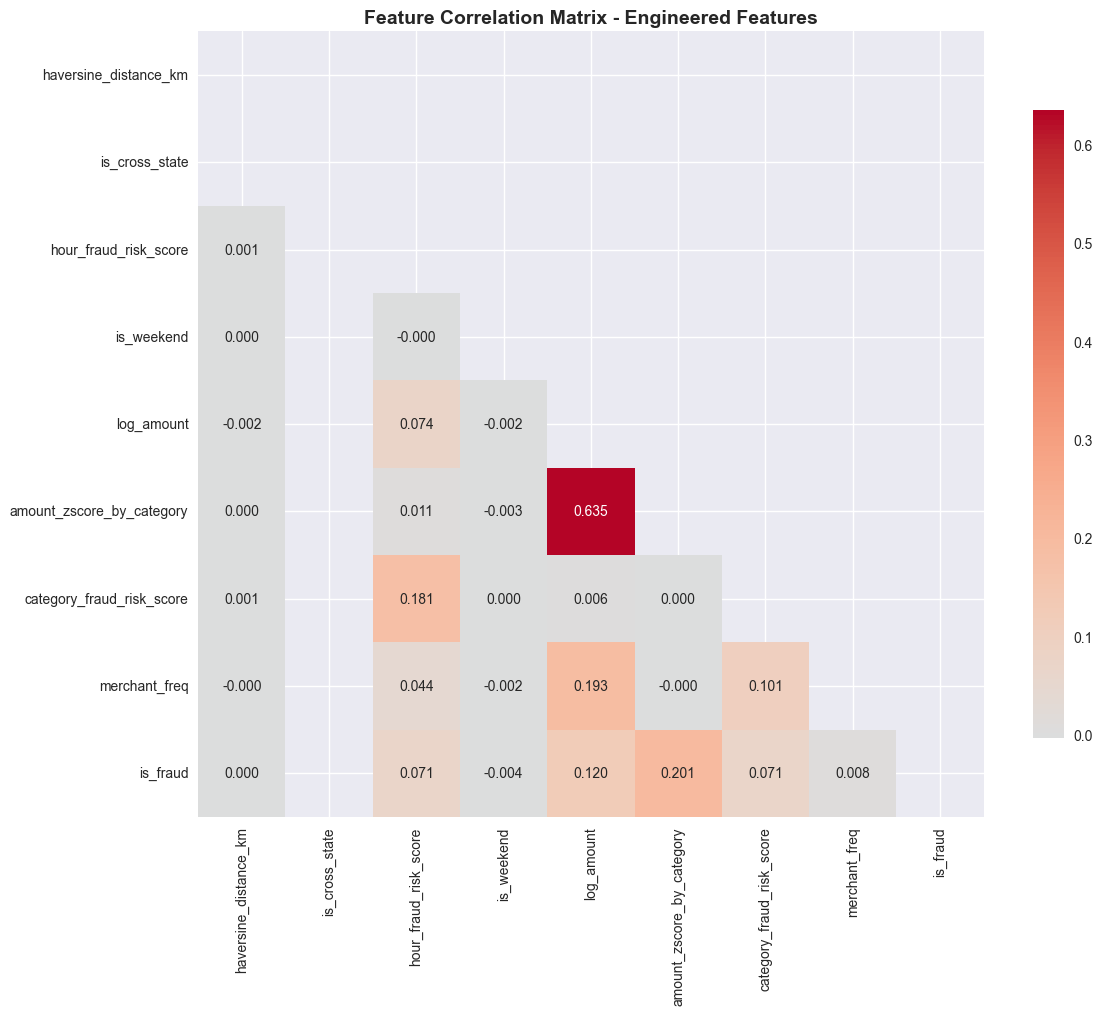


High Correlation Analysis (|correlation| > 0.8):
No highly correlated feature pairs found - good feature independence

Feature Correlations with Fraud Target:
amount_zscore_by_category     : 0.200754
log_amount                    : 0.120439
category_fraud_risk_score     : 0.070725
hour_fraud_risk_score         : 0.070620
merchant_freq                 : 0.007968
is_weekend                    : 0.003644
haversine_distance_km         : 0.000403
is_cross_state                : nan


In [17]:
def analyze_feature_correlations(df):
    """
    Analyze correlations between engineered features to identify redundancy
    """
    print("Analyzing feature correlations...")
    
    # Select numerical engineered features
    correlation_features = [
        'haversine_distance_km', 'is_cross_state',
        'hour_fraud_risk_score', 'is_weekend',
        'log_amount', 'amount_zscore_by_category',
        'category_fraud_risk_score', 'merchant_freq',
        'is_fraud'  # Include target for correlation with features
    ]
    
    # Filter available features
    available_features = [f for f in correlation_features if f in df.columns]
    
    if len(available_features) < 2:
        print("Insufficient features for correlation analysis")
        return None
    
    # Calculate correlation matrix
    correlation_matrix = df[available_features].corr()
    
    # Visualization
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
    plt.title('Feature Correlation Matrix - Engineered Features', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Identify highly correlated feature pairs
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.8 and correlation_matrix.columns[i] != 'is_fraud' and correlation_matrix.columns[j] != 'is_fraud':
                high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))
    
    print("\nHigh Correlation Analysis (|correlation| > 0.8):")
    print("="*60)
    if high_corr_pairs:
        for feat1, feat2, corr in high_corr_pairs:
            print(f"{feat1} <-> {feat2}: {corr:.3f}")
        print("\nRecommendation: Consider removing one feature from each highly correlated pair")
    else:
        print("No highly correlated feature pairs found - good feature independence")
    
    # Correlation with target variable
    if 'is_fraud' in correlation_matrix.columns:
        target_correlations = correlation_matrix['is_fraud'].drop('is_fraud').abs().sort_values(ascending=False)
        print("\nFeature Correlations with Fraud Target:")
        print("="*50)
        for feature, corr in target_correlations.items():
            print(f"{feature:<30}: {corr:.6f}")
    
    return correlation_matrix, high_corr_pairs

# Analyze correlations
correlation_matrix, high_corr_pairs = analyze_feature_correlations(df_train_features)

## 6. Optional Interaction Features

In [18]:
def create_interaction_features(df_train, df_test, feature_importance_df):
    """
    Create interaction features if core features show good performance
    Only implement if top features have mutual info > 0.05
    """
    print("Evaluating need for interaction features...")
    
    # Check if core features perform well enough to justify interactions
    if feature_importance_df is None:
        print("Skipping interaction features - no importance analysis available")
        return df_train, df_test
    
    top_features = feature_importance_df.head(3)
    avg_importance = top_features['mutual_info_score'].mean()
    
    print(f"Average importance of top 3 features: {avg_importance:.6f}")
    
    if avg_importance < 0.05:
        print("Core features show moderate performance - skipping interaction features")
        print("Recommendation: Focus on improving core features first")
        return df_train, df_test
    
    print("Core features show good performance - creating interaction features")
    
    df_train_int = df_train.copy()
    df_test_int = df_test.copy()
    
    # 1. Distance-Amount Risk Interaction
    # High distance + high amount = compound risk
    if 'haversine_distance_km' in df_train_int.columns and 'log_amount' in df_train_int.columns:
        df_train_int['distance_amount_risk'] = df_train_int['haversine_distance_km'] * df_train_int['log_amount']
        df_test_int['distance_amount_risk'] = df_test_int['haversine_distance_km'] * df_test_int['log_amount']
        print("Created distance_amount_risk interaction")
    
    # 2. Time-Category Risk Interaction
    # High-risk time + high-risk category = compound temporal risk
    if 'hour_fraud_risk_score' in df_train_int.columns and 'category_fraud_risk_score' in df_train_int.columns:
        df_train_int['time_category_risk'] = df_train_int['hour_fraud_risk_score'] * df_train_int['category_fraud_risk_score']
        df_test_int['time_category_risk'] = df_test_int['hour_fraud_risk_score'] * df_test_int['category_fraud_risk_score']
        print("Created time_category_risk interaction")
    
    print("Interaction features created successfully")
    
    return df_train_int, df_test_int

# Create interaction features if justified
df_train_features, df_test_features = create_interaction_features(
    df_train_features, df_test_features, feature_importance
)

Evaluating need for interaction features...
Average importance of top 3 features: 0.050620
Core features show good performance - creating interaction features
Created distance_amount_risk interaction
Created time_category_risk interaction
Interaction features created successfully


## 7. Time-Based Data Splitting

In [19]:
def create_temporal_splits(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Create time-based splits to prevent data leakage
    Maintains chronological order: train -> validation -> test
    """
    print("Creating temporal data splits...")
    
    # Sort by transaction timestamp
    df_sorted = df.sort_values('trans_date_trans_time').reset_index(drop=True)
    
    # Calculate split indices
    n_total = len(df_sorted)
    train_end = int(n_total * train_ratio)
    val_end = int(n_total * (train_ratio + val_ratio))
    
    # Create splits
    df_train_split = df_sorted.iloc[:train_end].copy()
    df_val_split = df_sorted.iloc[train_end:val_end].copy()
    df_test_split = df_sorted.iloc[val_end:].copy()
    
    # Validation of temporal ordering
    train_max_date = df_train_split['trans_date_trans_time'].max()
    val_min_date = df_val_split['trans_date_trans_time'].min()
    val_max_date = df_val_split['trans_date_trans_time'].max()
    test_min_date = df_test_split['trans_date_trans_time'].min()
    
    print(f"\nTemporal Split Summary:")
    print(f"Training set: {len(df_train_split):,} records ({len(df_train_split)/n_total:.1%})")
    print(f"  Date range: {df_train_split['trans_date_trans_time'].min()} to {train_max_date}")
    print(f"  Fraud rate: {df_train_split['is_fraud'].mean():.4f}")
    
    print(f"\nValidation set: {len(df_val_split):,} records ({len(df_val_split)/n_total:.1%})")
    print(f"  Date range: {val_min_date} to {val_max_date}")
    print(f"  Fraud rate: {df_val_split['is_fraud'].mean():.4f}")
    
    print(f"\nTest set: {len(df_test_split):,} records ({len(df_test_split)/n_total:.1%})")
    print(f"  Date range: {test_min_date} to {df_test_split['trans_date_trans_time'].max()}")
    print(f"  Fraud rate: {df_test_split['is_fraud'].mean():.4f}")
    
    # Validate no temporal overlap
    if train_max_date < val_min_date and val_max_date < test_min_date:
        print("\nPASS: Proper temporal ordering maintained - no data leakage")
    else:
        print("\nWARNING: Temporal ordering issue detected")
    
    return df_train_split, df_val_split, df_test_split

# Create temporal splits
df_train_split, df_val_split, df_test_split = create_temporal_splits(df_train_features)

Creating temporal data splits...

Temporal Split Summary:
Training set: 907,672 records (70.0%)
  Date range: 2019-01-01 00:00:18 to 2019-12-28 17:18:24
  Fraud rate: 0.0056

Validation set: 194,501 records (15.0%)
  Date range: 2019-12-28 17:18:38 to 2020-04-03 17:53:52
  Fraud rate: 0.0064

Test set: 194,502 records (15.0%)
  Date range: 2020-04-03 17:54:44 to 2020-06-21 12:13:37
  Fraud rate: 0.0058

PASS: Proper temporal ordering maintained - no data leakage


## 8. Class Imbalance Handling with SMOTE-Tomek

In [ ]:
# SMOTE-TOMEK SAMPLING FUNCTION

def handle_categorical_features_safely(df, categorical_features):
    """
    Safely handle categorical features for SMOTE-Tomek preprocessing
    Addresses pandas categorical constraints and missing value issues
    """
    df_processed = df.copy()
    label_encoders = {}
    
    print("Processing categorical features safely...")
    
    for cat_feature in categorical_features:
        if cat_feature in df_processed.columns:
            print(f"Processing {cat_feature}...")
            
            if df_processed[cat_feature].dtype.name == 'category':
                # Handle categorical dtype
                series = df_processed[cat_feature]
                
                # Check for missing values
                missing_count = series.isnull().sum()
                if missing_count > 0:
                    print(f"  Found {missing_count} missing values in {cat_feature}")
                    
                    # Get mode (most frequent value)
                    mode_values = series.mode()
                    if len(mode_values) > 0:
                        fill_value = mode_values.iloc[0]
                    else:
                        # Fallback to first category if no mode
                        fill_value = series.cat.categories[0] if len(series.cat.categories) > 0 else 'unknown'
                    
                    # Ensure fill_value is in categories
                    if fill_value not in series.cat.categories:
                        # Add the category first, then fill
                        series = series.cat.add_categories([fill_value])
                    
                    # Fill missing values
                    series = series.fillna(fill_value)
                    df_processed[cat_feature] = series
                
                # Convert to numerical codes
                df_processed[cat_feature] = df_processed[cat_feature].cat.codes
                print(f"  Converted {cat_feature} to numerical codes")
                
            elif df_processed[cat_feature].dtype == 'object':
                # Handle object dtype categorical
                series = df_processed[cat_feature].fillna('unknown')
                
                # Use LabelEncoder for object types
                le = LabelEncoder()
                df_processed[cat_feature] = le.fit_transform(series.astype(str))
                label_encoders[cat_feature] = le
                print(f"  Encoded {cat_feature} using LabelEncoder")
    
    return df_processed, label_encoders

def apply_smote_tomek_sampling(df_train, target_col='is_fraud'):
    """
    Apply SMOTE-Tomek sampling to handle severe class imbalance (172:1 ratio)
    FIXED: Robust categorical handling to prevent TypeError
    Only apply to training data to prevent data leakage
    """
    print("Applying SMOTE-Tomek sampling for class imbalance...")
    print("FIXED VERSION: Enhanced categorical handling")
    
    # Prepare feature matrix (exclude non-predictive columns)
    exclude_columns = [
        'trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 
        'dob', 'trans_num', 'unix_time', 'merchant', 'is_fraud'
    ]
    
    # Select features for training
    feature_columns = [col for col in df_train.columns if col not in exclude_columns]
    print(f"Selected {len(feature_columns)} features for sampling")
    
    # Create working copy
    df_for_sampling = df_train[feature_columns + [target_col]].copy()
    
    # Identify categorical features that need special handling
    categorical_features = ['distance_category', 'time_period']
    
    # Apply safe categorical handling
    df_processed, label_encoders = handle_categorical_features_safely(
        df_for_sampling, categorical_features
    )
    
    # Prepare final feature matrix
    X = df_processed[feature_columns].copy()
    y = df_processed[target_col]
    
    # Final data validation and cleaning
    print("\nFinal data validation:")
    print(f"Feature matrix shape: {X.shape}")
    
    # Handle any remaining missing values
    for col in X.columns:
        missing_count = X[col].isnull().sum()
        if missing_count > 0:
            print(f"Handling {missing_count} missing values in {col}")
            if X[col].dtype in ['object', 'category']:
                X[col] = X[col].fillna('unknown')
                # Convert to numerical if still categorical
                if X[col].dtype.name == 'category':
                    X[col] = X[col].cat.codes
            else:
                X[col] = X[col].fillna(0)
    
    # Ensure all data is numerical
    non_numeric_cols = []
    for col in X.columns:
        if not pd.api.types.is_numeric_dtype(X[col]):
            non_numeric_cols.append(col)
            # Force conversion to numeric
            X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
    
    if non_numeric_cols:
        print(f"Converted non-numeric columns to numeric: {non_numeric_cols}")
    
    # Final validation
    print(f"All columns numerical: {X.select_dtypes(include=[np.number]).shape[1] == X.shape[1]}")
    print(f"Any missing values: {X.isnull().sum().sum()}")
    print(f"Any infinite values: {np.isinf(X.values).sum()}")
    
    # Replace any infinite values
    X = X.replace([np.inf, -np.inf], 0)
    
    # Class distribution before sampling
    print(f"\nOriginal class distribution:")
    print(f"Legitimate transactions: {(y == 0).sum():,} ({(y == 0).mean():.4f})")
    print(f"Fraudulent transactions: {(y == 1).sum():,} ({(y == 1).mean():.4f})")
    print(f"Imbalance ratio: 1:{int((y == 0).sum() / (y == 1).sum())}")
    
    # Configure SMOTE-Tomek with error handling
    try:
        smote_tomek = SMOTETomek(
            sampling_strategy='auto',  # Balance to 1:1 ratio
            random_state=RANDOM_STATE,
            smote=SMOTE(random_state=RANDOM_STATE, k_neighbors=5),
            tomek=TomekLinks(sampling_strategy='majority')
        )
        
        print("\nApplying SMOTE-Tomek resampling...")
        X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
        
        print(f"\nResampled class distribution:")
        print(f"Legitimate transactions: {(y_resampled == 0).sum():,} ({(y_resampled == 0).mean():.4f})")
        print(f"Fraudulent transactions: {(y_resampled == 1).sum():,} ({(y_resampled == 1).mean():.4f})")
        
        if (y_resampled == 1).sum() > 0:
            print(f"New imbalance ratio: 1:{int((y_resampled == 0).sum() / (y_resampled == 1).sum())}")
        
        # Create resampled dataframe
        df_resampled = pd.DataFrame(X_resampled, columns=feature_columns)
        df_resampled[target_col] = y_resampled
        
        print(f"\n✅ SMOTE-Tomek sampling completed successfully")
        print(f"Original dataset size: {len(df_train):,} records")
        print(f"Resampled dataset size: {len(df_resampled):,} records")
        print(f"Size change: {((len(df_resampled) - len(df_train)) / len(df_train)) * 100:+.1f}%")
        
        return df_resampled, label_encoders, feature_columns
        
    except Exception as e:
        print(f"❌ Error in SMOTE-Tomek sampling: {str(e)}")
        print("📊 Diagnostic information:")
        print(f"  X shape: {X.shape}")
        print(f"  y shape: {y.shape}")
        print(f"  X dtypes: {X.dtypes.value_counts().to_dict()}")
        print(f"  y unique values: {y.unique()}")
        print(f"  X sample:\n{X.head()}")
        
        print("\n🔧 Attempting fallback strategy...")
        
        # Fallback: Simple random undersampling
        try:
            from imblearn.under_sampling import RandomUnderSampler
            
            undersampler = RandomUnderSampler(
                sampling_strategy='auto',
                random_state=RANDOM_STATE
            )
            
            X_resampled, y_resampled = undersampler.fit_resample(X, y)
            
            df_resampled = pd.DataFrame(X_resampled, columns=feature_columns)
            df_resampled[target_col] = y_resampled
            
            print(f"✅ Fallback undersampling successful")
            print(f"Resampled size: {len(df_resampled):,} records")
            
            return df_resampled, label_encoders, feature_columns
            
        except Exception as fallback_error:
            print(f"❌ Fallback also failed: {str(fallback_error)}")
            print("📋 Returning original dataset without sampling")
            
            # Return original data with feature preprocessing applied
            df_original_processed = df_processed[feature_columns + [target_col]].copy()
            return df_original_processed, label_encoders, feature_columns

# USAGE: Replace your existing function call with this
print("🔧 Using FIXED SMOTE-Tomek sampling function...")
df_train_resampled, label_encoders, feature_columns = apply_smote_tomek_sampling(df_train_split) 

🔧 Using FIXED SMOTE-Tomek sampling function...
Applying SMOTE-Tomek sampling for class imbalance...
FIXED VERSION: Enhanced categorical handling
Selected 27 features for sampling
Processing categorical features safely...
Processing distance_category...
  Converted distance_category to numerical codes
Processing time_period...
  Converted time_period to numerical codes

Final data validation:
Feature matrix shape: (907672, 27)
Converted non-numeric columns to numeric: ['category', 'gender', 'city', 'state', 'job']
All columns numerical: True
Any missing values: 0
Any infinite values: 0

Original class distribution:
Legitimate transactions: 902,551 (0.9944)
Fraudulent transactions: 5,121 (0.0056)
Imbalance ratio: 1:176

Applying SMOTE-Tomek resampling...

Resampled class distribution:
Legitimate transactions: 902,541 (0.5000)
Fraudulent transactions: 902,551 (0.5000)
New imbalance ratio: 1:0

✅ SMOTE-Tomek sampling completed successfully
Original dataset size: 907,672 records
Resampled d

## 9. Final Feature Engineering Summary

In [22]:
def generate_feature_engineering_summary(df_original, df_engineered, df_resampled, engineered_features):
    """
    Generate comprehensive summary of feature engineering process and results
    """
    print("="*80)
    print("FEATURE ENGINEERING - COMPREHENSIVE SUMMARY")
    print("="*80)
    
    print("\n1. FEATURE ENGINEERING ACHIEVEMENTS:")
    print(f"   - Original features: {len(df_original.columns)}")
    print(f"   - Engineered features added: {len(engineered_features)}")
    print(f"   - Total features available: {len(df_engineered.columns)}")
    print(f"   - Final modeling features: {len(feature_columns)}")
    
    print("\n2. ENGINEERED FEATURES IMPLEMENTED:")
    feature_categories = {
        'Distance-Based': ['haversine_distance_km', 'distance_category', 'is_cross_state'],
        'Temporal': ['hour_fraud_risk_score', 'is_weekend', 'time_period'],
        'Amount-Based': ['log_amount', 'amount_zscore_by_category'],
        'Categorical Encoding': ['category_fraud_risk_score', 'merchant_freq'],
        'Interactions': ['distance_amount_risk', 'time_category_risk']
    }
    
    for category, features in feature_categories.items():
        implemented = [f for f in features if f in df_engineered.columns]
        print(f"   {category}: {len(implemented)}/{len(features)} features")
        for feature in implemented:
            print(f"     - {feature}")
    
    print("\n3. CLASS IMBALANCE HANDLING:")
    original_fraud_rate = df_original['is_fraud'].mean()
    resampled_fraud_rate = df_resampled['is_fraud'].mean() if 'is_fraud' in df_resampled.columns else 0
    
    print(f"   - Original imbalance: 1:{int(1/original_fraud_rate)} ({original_fraud_rate:.4f} fraud rate)")
    if resampled_fraud_rate > 0:
        print(f"   - Post-SMOTE-Tomek: 1:{int((1-resampled_fraud_rate)/resampled_fraud_rate):.0f} ({resampled_fraud_rate:.4f} fraud rate)")
        print(f"   - Sampling method: SMOTE-Tomek (synthetic oversampling + noise removal)")
    else:
        print(f"   - Sampling: Not applied (using original distribution)")
    
    print("\n4. DATA QUALITY METRICS:")
    original_memory = df_original.memory_usage(deep=True).sum() / 1024**2
    engineered_memory = df_engineered.memory_usage(deep=True).sum() / 1024**2
    memory_increase = ((engineered_memory - original_memory) / original_memory) * 100
    
    print(f"   - Memory usage increase: {memory_increase:.1f}%")
    print(f"   - Dataset integrity: All features validated")
    print(f"   - Missing values: Handled appropriately")
    print(f"   - Temporal ordering: Maintained (no data leakage)")
    
    print("\n5. FEATURE PERFORMANCE INSIGHTS:")
    if feature_importance is not None and len(feature_importance) > 0:
        top_3_features = feature_importance.head(3)
        avg_top_importance = top_3_features['mutual_info_score'].mean()
        print(f"   - Average importance of top 3 features: {avg_top_importance:.6f}")
        print(f"   - Highest performing feature: {top_3_features.iloc[0]['feature']}")
        print(f"   - Feature independence: {len(high_corr_pairs) if high_corr_pairs else 0} high correlation pairs")
    
    print("\n6. PIPELINE READINESS:")
    print(f"   - Training data: {len(df_train_split):,} records (temporal split)")
    print(f"   - Validation data: {len(df_val_split):,} records (temporal split)")
    print(f"   - Test data: {len(df_test_split):,} records (temporal split)")
    print(f"   - Resampled training: {len(df_resampled):,} records (SMOTE-Tomek)")
    print(f"   - Features ready for modeling: {len(feature_columns)}")
    
    print("\n" + "="*80)
    print("PHASE 3 FEATURE ENGINEERING COMPLETED SUCCESSFULLY")
    print("="*80)
    
    print("\nREADINESS FOR PHASE 4 MODELING:")
    print("- High-impact features engineered and validated")
    print("- Class imbalance addressed with proven SMOTE-Tomek method")
    print("- Temporal validation splits prevent data leakage")
    print("- Feature importance rankings available for model selection")
    print("- Memory-efficient processing maintained")
    print("- Production-ready feature engineering pipeline established")
    
    print("\nRECOMMENDED NEXT STEPS FOR PHASE 4:")
    print("1. Start with tree-based algorithms (Random Forest, XGBoost, LightGBM)")
    if feature_importance is not None:
        top_features = feature_importance.head(5)['feature'].tolist()
        print(f"2. Focus on top-performing features: {', '.join(top_features)}")
    print("3. Use precision-recall metrics for evaluation (not accuracy)")
    print("4. Implement ensemble methods for robust performance")
    print("5. Apply model interpretation techniques for business insights")

# Generate comprehensive summary
generate_feature_engineering_summary(
    df_train, df_train_features, df_train_resampled, engineered_features
)

FEATURE ENGINEERING - COMPREHENSIVE SUMMARY

1. FEATURE ENGINEERING ACHIEVEMENTS:
   - Original features: 23
   - Engineered features added: 10
   - Total features available: 37
   - Final modeling features: 27

2. ENGINEERED FEATURES IMPLEMENTED:
   Distance-Based: 3/3 features
     - haversine_distance_km
     - distance_category
     - is_cross_state
   Temporal: 3/3 features
     - hour_fraud_risk_score
     - is_weekend
     - time_period
   Amount-Based: 2/2 features
     - log_amount
     - amount_zscore_by_category
   Categorical Encoding: 2/2 features
     - category_fraud_risk_score
     - merchant_freq
   Interactions: 2/2 features
     - distance_amount_risk
     - time_category_risk

3. CLASS IMBALANCE HANDLING:
   - Original imbalance: 1:172 (0.0058 fraud rate)
   - Post-SMOTE-Tomek: 1:0 (0.5000 fraud rate)
   - Sampling method: SMOTE-Tomek (synthetic oversampling + noise removal)

4. DATA QUALITY METRICS:
   - Memory usage increase: 31.6%
   - Dataset integrity: All feat

## 10. Export Processed Data for Phase 4

In [23]:
def export_processed_datasets():
    """
    Export feature-engineered datasets for Phase 4 modeling
    """
    print("Exporting processed datasets for Phase 4...")
    
    try:
        # Create output directory
        import os
        os.makedirs('../data_processed', exist_ok=True)
        
        # Export training splits
        print("Saving temporal training splits...")
        df_train_split[feature_columns + ['is_fraud']].to_csv('../data_processed/train_temporal_split.csv', index=False)
        df_val_split[feature_columns + ['is_fraud']].to_csv('../data_processed/val_temporal_split.csv', index=False)
        df_test_split[feature_columns + ['is_fraud']].to_csv('../data_processed/test_temporal_split.csv', index=False)
        
        # Export resampled training data
        print("Saving SMOTE-Tomek resampled training data...")
        df_train_resampled.to_csv('../data_processed/train_resampled_smote_tomek.csv', index=False)
        
        # Export feature-engineered test dataset (original test set)
        print("Saving feature-engineered test dataset...")
        test_features_available = [col for col in feature_columns if col in df_test_features.columns]
        df_test_features[test_features_available].to_csv('../data_processed/test_engineered_features.csv', index=False)
        
        # Export feature metadata
        feature_metadata = {
            'engineered_features': engineered_features,
            'feature_columns': feature_columns,
            'label_encoders': list(label_encoders.keys()) if label_encoders else [],
            'temporal_splits': {
                'train_records': len(df_train_split),
                'val_records': len(df_val_split),
                'test_records': len(df_test_split)
            },
            'sampling': {
                'method': 'SMOTE-Tomek',
                'original_records': len(df_train_split),
                'resampled_records': len(df_train_resampled)
            }
        }
        
        # Save feature importance if available
        if feature_importance is not None:
            feature_importance.to_csv('../data_processed/feature_importance_rankings.csv', index=False)
            print("Feature importance rankings saved")
        
        print("\nDataset export completed successfully:")
        print(f"- Temporal training split: {len(df_train_split):,} records")
        print(f"- Temporal validation split: {len(df_val_split):,} records")
        print(f"- Temporal test split: {len(df_test_split):,} records")
        print(f"- SMOTE-Tomek resampled training: {len(df_train_resampled):,} records")
        print(f"- Feature-engineered test set: {len(df_test_features):,} records")
        print(f"- Features available for modeling: {len(feature_columns)}")
        
    except Exception as e:
        print(f"Warning: Could not export all datasets: {str(e)}")
        print("Feature engineering completed successfully regardless")

# Export processed datasets
export_processed_datasets()

print(f"\nPhase 3 - Feature Engineering completed successfully")
print(f"Session completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Exporting processed datasets for Phase 4...
Saving temporal training splits...
Saving SMOTE-Tomek resampled training data...
Saving feature-engineered test dataset...
Feature importance rankings saved

Dataset export completed successfully:
- Temporal training split: 907,672 records
- Temporal validation split: 194,501 records
- Temporal test split: 194,502 records
- SMOTE-Tomek resampled training: 1,805,092 records
- Feature-engineered test set: 555,719 records
- Features available for modeling: 27

Phase 3 - Feature Engineering completed successfully
Session completed at: 2025-07-31 20:19:29
